In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.regression.linear_model import OLS
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor

%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12, 8)
sns.set()

In [2]:
# Definições das funções

# Gráfico de correlação campos Nan. Lista somente as colunas que possuem dados Nan
def null_correlation(df):
    corr = df.isnull().corr()
    cols = corr.columns[corr.count()>0]
    corr = corr.loc[cols, cols]
    cmap=sns.diverging_palette(20, 220, n=200)
    mask = np.triu(np.ones(corr.shape)).astype(np.bool)  #constrói em forma triangular
    sns.heatmap(corr, cmap = cmap,mask=mask, annot=True,vmin=-1, vmax=1,  fmt='.2f') #duas casas decimais
    plt.title('Correlação de dados Nan', fontsize=18)
    plt.show()
    
# Dataframe auxiliar com dados do dataframe para visualizar os tipos de dados e a quantidade de dados Nan
def aux_dataframe(df):
    df_aux = pd.DataFrame({
                        'Column': df.columns,
                        'Type': df.dtypes,
                        'Unique': df.nunique(),
                        'Nan': df.isnull().sum()
                           })
    df_aux['Nan_%'] = round(df_aux['Nan']/df.shape[0]*100,2)
    return df_aux

# Análise inicial dados de test

Inicialmente foi analisado os dados de test para entender quais colunas virão e como os dados virão.
A partir desta análise, serão identificadas a priori quais colunas, dos dados de treino, serão exploradas.

In [3]:
test = pd.read_csv('test.csv')

In [4]:
test.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,PR,22,F,3,1,1,5,1,...,40.0,420.0,B,A,C,A,A,C,C,A
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,MA,26,F,3,1,1,8,1,...,100.0,580.0,E,B,C,B,B,B,F,A
2,b38a03232f43b11c9d0788abaf060f7366053b6d,23,CE,21,M,1,1,2,0,2,...,80.0,320.0,E,E,D,B,B,A,NaN,A
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,PA,27,F,3,1,1,8,1,...,NaN,NaN,H,E,G,B,B,A,NaN,A
4,715494628a50142ce8cb17191cfe6d0f3cae0934,41,PR,18,M,1,1,2,0,2,...,0.0,320.0,D,H,H,C,B,A,NaN,A


In [5]:
test.shape

(4576, 47)

In [6]:
# Chamada classe para criação de dataframe auxiliar
test_aux = aux_dataframe(test)

In [7]:
# Lista somente colunas que possuem dados Nan
columns_null = test_aux[test_aux['Nan']!=0].index
test_aux[ test_aux['Nan']!=0]

,Column,Type,Unique,Nan,Nan_%
TP_ENSINO,TP_ENSINO,float64,3,3096,67.66
TP_DEPENDENCIA_ADM_ESC,TP_DEPENDENCIA_ADM_ESC,float64,4,3096,67.66
NU_NOTA_CN,NU_NOTA_CN,float64,1823,1134,24.78
NU_NOTA_CH,NU_NOTA_CH,float64,1969,1134,24.78
NU_NOTA_LC,NU_NOTA_LC,float64,1839,1199,26.20
TP_STATUS_REDACAO,TP_STATUS_REDACAO,float64,9,1199,26.20
NU_NOTA_COMP1,NU_NOTA_COMP1,float64,10,1199,26.20
NU_NOTA_COMP2,NU_NOTA_COMP2,float64,10,1199,26.20
NU_NOTA_COMP3,NU_NOTA_COMP3,float64,11,1199,26.20
NU_NOTA_COMP4,NU_NOTA_COMP4,float64,11,1199,26.20


In [8]:
columns_null = list(columns_null)   
columns_null.append('NU_INSCRICAO')

In [9]:
# Verifica relação entre presença na prova e a nota Nan
# 0 - Faltou à prova
# 2 - Eliminado na prova

# TP_PRESENCA_CN X NU_NOTA_CN
print(test.loc[test.NU_NOTA_CN.isnull(), 'TP_PRESENCA_CN'].value_counts())
# TP_PRESENCA_CH X NU_NOTA_CH
print(test.loc[test.NU_NOTA_CH.isnull(), 'TP_PRESENCA_CH'].value_counts())
# TP_PRESENCA_LC X NU_NOTA_LC
print(test.loc[test.NU_NOTA_LC.isnull(), 'TP_PRESENCA_LC'].value_counts())

0    1134
Name: TP_PRESENCA_CN, dtype: int64
0    1134
Name: TP_PRESENCA_CH, dtype: int64
0    1195
2       4
Name: TP_PRESENCA_LC, dtype: int64


In [10]:
# Preenchido com 0 as notas que os alunos faltaram ou forma eliminados na prova
col = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC']
for i in col:
    test[i] = test[i].fillna(0)

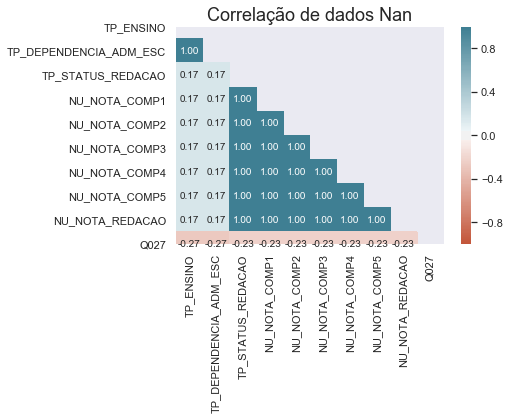

In [11]:
# Chamada a classe criada
# Interpretação do gráfico: 17% dos linhas que possuem NU_NOTA_COMP1 = Nan, possuem TP_ENSINO = Nan
#                           100% das linhas que possuem NU_NOTA_COMP1 = Nan possuem NU_NOTA_COMP2 = Nan  
null_correlation(test)

In [12]:
test.loc[test.NU_NOTA_COMP1.isnull(),columns_null]

,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q027,NU_INSCRICAO
3,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70b682d9a3636be23f6120fa9d6b164eb3c6002d
10,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8b7c167ea7b55c8168ec60c3851b1b598a8fbd11
11,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,db4da599aab5bb08dce27094a35fd3e36cd0abce
16,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,fbfa8cde21a692b51fb86342110b4a334a0fcfdb
17,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,ca8477c8493b09f34d17bb287f9bacf2dd744c32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4543,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,098eabcd83d72785beca4cdff3d5cfbc71904a48
4546,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,b8ec140a86a7a6e569f3eda9ae9083183ca2e386
4547,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,40a9b86a4efdd7ab5ee6fc26de9a984946896deb
4549,NaN,NaN,419.9,517.1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,ec73ba109d1a91299e071b2a95f79c36c1c6e069


In [13]:
#Visualizando os dados de teste, somente para insight
columns_nota = [ 'NU_NOTA_COMP1', 'NU_NOTA_REDACAO',
                'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']

In [14]:
test[columns_nota].describe()

,NU_NOTA_COMP1,NU_NOTA_REDACAO,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5
count,3377.000000,3377.000000,3377.000000,3377.000000,3377.000000,3377.000000
mean,119.626888,527.491857,111.915902,106.384365,112.881256,76.683447
std,29.028146,151.979490,33.296849,33.834492,33.202244,42.985637
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,120.000000,440.000000,100.000000,80.000000,100.000000,40.000000
50%,120.000000,540.000000,120.000000,100.000000,120.000000,80.000000
75%,140.000000,600.000000,120.000000,120.000000,120.000000,100.000000
max,200.000000,980.000000,200.000000,200.000000,200.000000,200.000000


In [15]:
# Chamada classe para criação de dataframe auxiliar
test_aux = aux_dataframe(test)
# Lista somente colunas que possuem dados Nan
test_aux[test_aux['Nan']!=0]

,Column,Type,Unique,Nan,Nan_%
TP_ENSINO,TP_ENSINO,float64,3,3096,67.66
TP_DEPENDENCIA_ADM_ESC,TP_DEPENDENCIA_ADM_ESC,float64,4,3096,67.66
TP_STATUS_REDACAO,TP_STATUS_REDACAO,float64,9,1199,26.20
NU_NOTA_COMP1,NU_NOTA_COMP1,float64,10,1199,26.20
NU_NOTA_COMP2,NU_NOTA_COMP2,float64,10,1199,26.20
NU_NOTA_COMP3,NU_NOTA_COMP3,float64,11,1199,26.20
NU_NOTA_COMP4,NU_NOTA_COMP4,float64,11,1199,26.20
NU_NOTA_COMP5,NU_NOTA_COMP5,float64,11,1199,26.20
NU_NOTA_REDACAO,NU_NOTA_REDACAO,float64,44,1199,26.20
Q027,Q027,object,13,2488,54.37


In [16]:
columns_to_work = list(test_aux.index)

### Dados de treino
Verificando colunas nulas.
Removendo colunas que não fazer parte dos dados de teste.
Preenchendo NU_NOTA_CN e NU_NOTA_CH com a nota média.

In [17]:
treino = pd.read_csv('train.csv')

In [18]:
treino.shape

(13730, 167)

In [19]:
# A coluna TP_PRESENCA_MT não esta presente na base de test, portanto não será carregada nos dados de treino. 
# Mas serão removidos todos os registros cujo NU_NOTA_MT seja null, pois estes alunos
# não compareceram ou foram eliminados na prova.
print(treino.loc[treino.NU_NOTA_MT.isnull(), 'TP_PRESENCA_MT'].value_counts())

0    3592
2       5
Name: TP_PRESENCA_MT, dtype: int64


In [20]:
# Dataframe de treino somente com as colunas presente no dataframe de test
columns_to_work.append('NU_NOTA_MT')
treino1 = treino[columns_to_work]

In [21]:
treino1.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,NU_NOTA_MT
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,...,520.0,D,D,C,A,A,C,H,A,399.4
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,...,580.0,A,A,B,A,A,A,NaN,A,459.8
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,...,NaN,D,D,C,A,A,A,NaN,A,NaN
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,...,NaN,H,E,E,C,B,C,F,D,NaN
4,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,AM,28,M,2,1,1,4,1,...,NaN,E,D,C,A,A,B,F,A,NaN


In [22]:
# Remove registros com NU_NOTA_MT = 'Nan'
treino1 = treino1.drop(treino1[treino1.NU_NOTA_MT.isnull()].index)

In [23]:
treino1_aux = aux_dataframe(treino1)
treino1_aux[treino1_aux.Nan !=0]

,Column,Type,Unique,Nan,Nan_%
TP_ENSINO,TP_ENSINO,float64,3,6494,64.09
TP_DEPENDENCIA_ADM_ESC,TP_DEPENDENCIA_ADM_ESC,float64,4,6494,64.09
NU_NOTA_CN,NU_NOTA_CN,float64,2680,36,0.36
NU_NOTA_CH,NU_NOTA_CH,float64,2963,36,0.36
Q027,Q027,object,13,6126,60.46


In [24]:
# Remove os 36 registros 
treino1 = treino1.drop(treino1[treino1.NU_NOTA_CN.isna()].index)

In [25]:
treino1_aux = aux_dataframe(treino1)
treino1_aux[treino1_aux.Nan!=0]

,Column,Type,Unique,Nan,Nan_%
TP_ENSINO,TP_ENSINO,float64,3,6469,64.07
TP_DEPENDENCIA_ADM_ESC,TP_DEPENDENCIA_ADM_ESC,float64,4,6469,64.07
Q027,Q027,object,13,6106,60.47


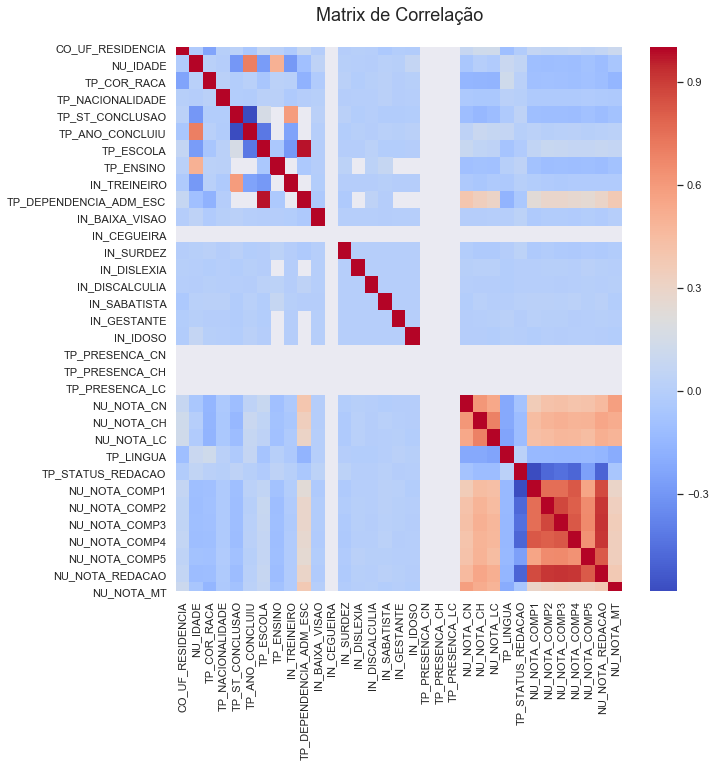

In [26]:
# Visualiza correlação das variáveis numéricas
type_number = treino1.select_dtypes(exclude=[object]).columns
fig, ax = plt.subplots(figsize=(10,10)) 
corr = treino1[type_number].corr()
sns.heatmap(corr, ax=ax,  cmap = 'coolwarm')
plt.title('Matrix de Correlação\n', fontsize=18)
plt.show()

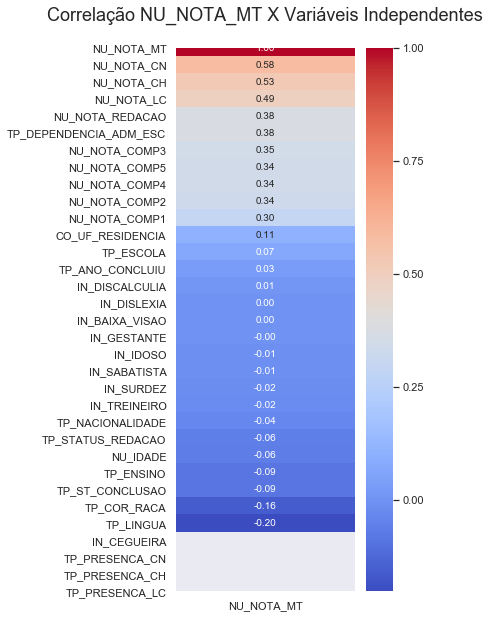

In [27]:
# Visualização detalhada da correlação das variaveis independentes com a variavel target 
plt.figure(figsize(4,10))
cmap=sns.diverging_palette(20, 220, n=200)
sns.heatmap(corr[['NU_NOTA_MT']].sort_values('NU_NOTA_MT',ascending=False),
            cmap = 'coolwarm',
            annot=True,
            fmt='.2f'
           )
plt.title('Correlação NU_NOTA_MT X Variáveis Independentes\n', fontsize=18)
plt.show()

- As variáveis que possuem pouca correlação e que possuem muitos dados nulos não serão utilizados como 
parâmetro no algoritmo de ML

In [28]:
# Juntar os dados de treino e teste para facilitar as transformações
# Nesta junção as NU_NOTA_MT do index test serão NAN
# Cria um dataframe multindex
df = pd.concat([treino1, test], keys=['train', 'test'], sort=True)

In [29]:
df.head()

CO_PROVA_CH  \
train 0  9cd70f1b922e02bd33453b3f607f5a644fb9b1b8   
      1  909237ab0d84688e10c0470e2997348aff585273   
      5  f48d390ab6a2428e659c37fb8a9d00afde621889   
      6  942ab3dc020af4cf53740b6b07e9dd7060b24164   
      7  909237ab0d84688e10c0470e2997348aff585273   

                                      CO_PROVA_CN  \
train 0  16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2   
      1  b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7   
      5  c8328ebc6f3238e06076c481bc1b82b8301e7a3f   
      6  66b1dad288e13be0992bae01e81f71eca1c6e8a6   
      7  b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7   

                                      CO_PROVA_LC  \
train 0  01af53cd161a420fff1767129c10de560cc264dd   
      1  01af53cd161a420fff1767129c10de560cc264dd   
      5  01abbb7f1a90505385f44eec9905f82ca2a42cfd   
      6  5aebe5cad7fabc1545ac7fba07a4e6177f98483c   
      7  72f80e4b3150c627c7ffc93cfe0fa13a9989b610   

                                      CO_PROVA_MT  CO_UF_RESIDENCIA  \
train 0  97caab1e1533dba217deb7ef41490f52e459ab01                43   
      1  97caab1e1533dba217deb7ef41490f52e459ab01                23   
      5  81d0ee00ef42a7c23eb04496458c03d4c5b9c31a                29   
      6  767a32545304ed293242d528f54d4edb1369f910                51   
      7  577f8968d95046f5eb5cc158608e12fa9ba34c85                43   

         IN_BAIXA_VISAO  IN_CEGUEIRA  IN_DISCALCULIA  IN_DISLEXIA  \
train 0               0            0               0            0   
      1               0            0               0            0   
      5               0            0               0            0   
      6               0            0               0            0   
      7               0            0               0            0   

         IN_GESTANTE  ...  TP_ENSINO  TP_ESCOLA  TP_LINGUA  TP_NACIONALIDADE  \
train 0            0  ...        NaN          1          1                 1   
      1            0  ...        1.0          2          1                 1   
      5            0  ...        NaN          1          0                 1   
      6            0  ...        1.0          2          0                 1   
      7            0  ...        NaN          1          0                 1   

         TP_PRESENCA_CH TP_PRESENCA_CN  TP_PRESENCA_LC  TP_SEXO  \
train 0               1              1               1        M   
      1               1              1               1        F   
      5               1              1               1        F   
      6               1              1               1        F   
      7               1              1               1        F   

         TP_STATUS_REDACAO  TP_ST_CONCLUSAO  
train 0                1.0                1  
      1                1.0                2  
      5                1.0                1  
      6                1.0                2  
      7                1.0                1  

[5 rows x 48 columns]

In [30]:
df.tail()

CO_PROVA_CH  \
test 4571  9cd70f1b922e02bd33453b3f607f5a644fb9b1b8   
     4572  9cd70f1b922e02bd33453b3f607f5a644fb9b1b8   
     4573  909237ab0d84688e10c0470e2997348aff585273   
     4574  942ab3dc020af4cf53740b6b07e9dd7060b24164   
     4575  2d22ac1d42e6187f09ee6c578df187a760123ccf   

                                        CO_PROVA_CN  \
test 4571  16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2   
     4572  16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2   
     4573  b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7   
     4574  66b1dad288e13be0992bae01e81f71eca1c6e8a6   
     4575  2d22ac1d42e6187f09ee6c578df187a760123ccf   

                                        CO_PROVA_LC  \
test 4571  01abbb7f1a90505385f44eec9905f82ca2a42cfd   
     4572  72f80e4b3150c627c7ffc93cfe0fa13a9989b610   
     4573  01af53cd161a420fff1767129c10de560cc264dd   
     4574  72f80e4b3150c627c7ffc93cfe0fa13a9989b610   
     4575  2d22ac1d42e6187f09ee6c578df187a760123ccf   

                                        CO_PROVA_MT  CO_UF_RESIDENCIA  \
test 4571  81d0ee00ef42a7c23eb04496458c03d4c5b9c31a                41   
     4572  577f8968d95046f5eb5cc158608e12fa9ba34c85                35   
     4573  97caab1e1533dba217deb7ef41490f52e459ab01                35   
     4574  577f8968d95046f5eb5cc158608e12fa9ba34c85                52   
     4575  2d22ac1d42e6187f09ee6c578df187a760123ccf                33   

           IN_BAIXA_VISAO  IN_CEGUEIRA  IN_DISCALCULIA  IN_DISLEXIA  \
test 4571               0            0               0            0   
     4572               0            0               0            0   
     4573               0            0               0            0   
     4574               0            0               0            0   
     4575               0            0               0            0   

           IN_GESTANTE  ...  TP_ENSINO  TP_ESCOLA  TP_LINGUA  \
test 4571            0  ...        1.0          2          0   
     4572            0  ...        1.0          2          1   
     4573            0  ...        NaN          1          0   
     4574            0  ...        NaN          1          1   
     4575            0  ...        NaN          1          1   

           TP_NACIONALIDADE  TP_PRESENCA_CH TP_PRESENCA_CN  TP_PRESENCA_LC  \
test 4571                 1               1              1               1   
     4572                 1               1              1               1   
     4573                 1               1              1               1   
     4574                 2               1              1               1   
     4575                 1               0              0               0   

           TP_SEXO  TP_STATUS_REDACAO  TP_ST_CONCLUSAO  
test 4571        F                1.0                2  
     4572        M                1.0                2  
     4573        M                1.0                1  
     4574        M                1.0                3  
     4575        M                NaN                1  

[5 rows x 48 columns]

In [31]:
df.xs('test').head()

,CO_PROVA_CH,CO_PROVA_CN,CO_PROVA_LC,CO_PROVA_MT,CO_UF_RESIDENCIA,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_DISCALCULIA,IN_DISLEXIA,IN_GESTANTE,...,TP_ENSINO,TP_ESCOLA,TP_LINGUA,TP_NACIONALIDADE,TP_PRESENCA_CH,TP_PRESENCA_CN,TP_PRESENCA_LC,TP_SEXO,TP_STATUS_REDACAO,TP_ST_CONCLUSAO
0,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,01abbb7f1a90505385f44eec9905f82ca2a42cfd,81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,41,0,0,0,0,0,...,NaN,1,0,1,1,1,1,F,1.0,1
1,f48d390ab6a2428e659c37fb8a9d00afde621889,c8328ebc6f3238e06076c481bc1b82b8301e7a3f,72f80e4b3150c627c7ffc93cfe0fa13a9989b610,577f8968d95046f5eb5cc158608e12fa9ba34c85,21,0,0,0,0,0,...,NaN,1,1,1,1,1,1,F,1.0,1
2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,23,0,0,0,0,0,...,3.0,2,0,1,1,1,1,M,1.0,2
3,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,15,0,0,0,0,0,...,NaN,1,0,1,0,0,0,F,NaN,1
4,942ab3dc020af4cf53740b6b07e9dd7060b24164,66b1dad288e13be0992bae01e81f71eca1c6e8a6,5aebe5cad7fabc1545ac7fba07a4e6177f98483c,767a32545304ed293242d528f54d4edb1369f910,41,0,0,0,0,0,...,1.0,2,1,1,1,1,1,M,1.0,2


# Tratativa

- Serão ignorado as colunas TP_ENSINO, TP_DEPENDENCIA_ADM_ESC e Q027 que possuem mais de 60% de dados Nan na base de treino.
- As colunas 'NU_NOTA_CN' e 'NU_NOTA_CH' com valores Nan foram removidos da base de treino.
- As colunas NU_NOTA_COMP na base de teste possuem várias linhas NAN que serão tratadas posteriormente.

### Análise das variáveis pela correlação e treino1_aux

- IN_CEGUEIRA só existe um registro, será removido da análise.
- TP_PRESENCA_CN, TP_PRESENCA_CH, TP_PRESENCA_LC, TP_STATUS_REDACAO estão relacionado com as respectivas nota, serão removido da análise.
- IN_DISCALCULIA, IN_DISLEXIA, IN_BAIXA_VISAO, IN_GESTANTE, IN_IDOSO, IN_SURDEZ, IN_SABATISTA correlação ~ 0  com NU_NOTA_MT, por conta da grande diferença de registros 0 e 1. Serão removidos da análise.
- CO_UF_RESIDENCIA será substituido por regiões geográficas. Será removido da análise.

In [32]:
columns = ['IN_DISCALCULIA', 'IN_DISLEXIA', 'IN_BAIXA_VISAO', 'IN_GESTANTE', 'IN_IDOSO', 'IN_SURDEZ', 'IN_SABATISTA']
for i in columns:
    print(f' {i} \n  {treino1[i].value_counts()} \n ')  

 IN_DISCALCULIA 
  0    10096
1        1
Name: IN_DISCALCULIA, dtype: int64 
 
 IN_DISLEXIA 
  0    10096
1        1
Name: IN_DISLEXIA, dtype: int64 
 
 IN_BAIXA_VISAO 
  0    10086
1       11
Name: IN_BAIXA_VISAO, dtype: int64 
 
 IN_GESTANTE 
  0    10093
1        4
Name: IN_GESTANTE, dtype: int64 
 
 IN_IDOSO 
  0    10096
1        1
Name: IN_IDOSO, dtype: int64 
 
 IN_SURDEZ 
  0    10093
1        4
Name: IN_SURDEZ, dtype: int64 
 
 IN_SABATISTA 
  0    9998
1      99
Name: IN_SABATISTA, dtype: int64 
 


In [33]:
# Variáveis categóricas que poderam ser transformadas
# CO_PROVA_CH, CO_PROVA_CN, CO_PROVA_LC, CO_PROVA_MT não são relevantes para nosso modelo. Serão removidas.
df.select_dtypes(include=object).columns

Index(['CO_PROVA_CH', 'CO_PROVA_CN', 'CO_PROVA_LC', 'CO_PROVA_MT',
       'NU_INSCRICAO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q027',
       'Q047', 'SG_UF_RESIDENCIA', 'TP_SEXO'],
      dtype='object')

In [34]:
col_delete = ['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'Q027',
              'IN_CEGUEIRA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_STATUS_REDACAO', 
              'IN_DISCALCULIA', 'IN_DISLEXIA', 'IN_BAIXA_VISAO', 'IN_GESTANTE', 'IN_IDOSO', 'IN_SURDEZ', 
              'IN_SABATISTA', 'CO_UF_RESIDENCIA',  'CO_PROVA_CH', 'CO_PROVA_CN', 'CO_PROVA_LC', 
              'CO_PROVA_MT'
             ]
df1 = df.drop(col_delete, axis=1)

In [35]:
df1.columns

Index(['IN_TREINEIRO', 'NU_IDADE', 'NU_INSCRICAO', 'NU_NOTA_CH', 'NU_NOTA_CN',
       'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'Q001',
       'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q047', 'SG_UF_RESIDENCIA',
       'TP_ANO_CONCLUIU', 'TP_COR_RACA', 'TP_ESCOLA', 'TP_LINGUA',
       'TP_NACIONALIDADE', 'TP_SEXO', 'TP_ST_CONCLUSAO'],
      dtype='object')

## Transformações nas variáveis

- 'Q001', 'Q002', 'Q006','Q024', 'Q025', 'Q026', 'Q047', 'SG_UF_RESIDENCIA','TP_COR_RACA', 'TP_ESCOLA', 'TP_SEXO', 'TP_NACIONALIDADE','TP_ST_CONCLUSAO' serão transformadados em numéricos.

In [36]:
df2 = df1.copy()

In [37]:
# Como possuem variabilidade de valores, serão transformados em numérico mas não serão colunas binárias
columns = ['Q001', 'Q002', 'Q006',  'Q026', 'Q047', 'SG_UF_RESIDENCIA',
           'TP_COR_RACA', 'TP_ESCOLA', 'TP_SEXO', 'Q025','TP_NACIONALIDADE','TP_ST_CONCLUSAO',
           'Q024'
          ]

lab_encoder = preprocessing.LabelEncoder()
for col in columns:
    lab_encoder.fit(df2[col])
    df2[col] = lab_encoder.transform(df2[col])    

### Classe para cálculos de métricas para a regressão linear

In [38]:
def press_statistic(y_true, y_pred, xs):
    res = y_pred - y_true
    hat = xs.dot(np.linalg.pinv(xs))
    den = (1 - np.diagonal(hat))
    sqr = np.square(res/den)
    return sqr.sum()

def predicted_r2(y_true, y_pred, xs):
    # é uma forma de validar com o modelo esta acertando as previsões
    press = press_statistic(y_true=y_true,
                            y_pred=y_pred,
                            xs=xs
    )

    sst  = np.square( y_true - y_true.mean() ).sum()
    return 1 - press / sst

In [39]:
def adjusted_r2(r2, shape):
    # é uma forma de validar se as variáveis inseridas no modelo estão realmente agregando ao modelo
    # se o valor retornado começar a diminuir com relação a outro modelo, a inserção de novas variáveis 
    #não será mais significativo ao modelo
    adj_r2 = (1 - (1 - r2) * ((shape[0] - 1) / 
          (shape[0] - shape[1] - 1)))
    return adj_r2

## Modelo de Regressão

In [40]:
df2.columns

Index(['IN_TREINEIRO', 'NU_IDADE', 'NU_INSCRICAO', 'NU_NOTA_CH', 'NU_NOTA_CN',
       'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'Q001',
       'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q047', 'SG_UF_RESIDENCIA',
       'TP_ANO_CONCLUIU', 'TP_COR_RACA', 'TP_ESCOLA', 'TP_LINGUA',
       'TP_NACIONALIDADE', 'TP_SEXO', 'TP_ST_CONCLUSAO'],
      dtype='object')

In [41]:
X = df2.xs('train').drop(['NU_NOTA_MT', 'NU_INSCRICAO'], axis=1 )
y = df2.xs('train').NU_NOTA_MT 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=250 )

In [42]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
predict = regr.predict(X_test)

In [44]:
print('Mean squared error: ' ,mean_squared_error(y_test, predict))
print('R2 score: ', r2_score(y_test, predict))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict), X_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict, X_test))

Mean squared error:  5586.049797353438
R2 score:  0.4407810591422725
Adjusted R2: 0.4386228741248611
Predicted R2: 0.4314143321058779


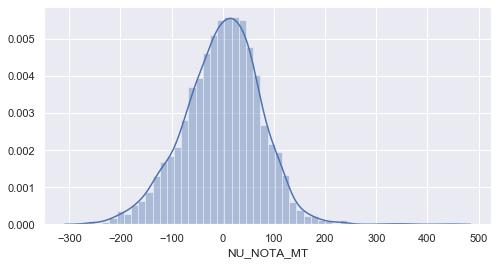

In [45]:
residuos = predict - y_test
plt.figure(figsize=(8,4)) 
sns.distplot(residuos)
plt.show()

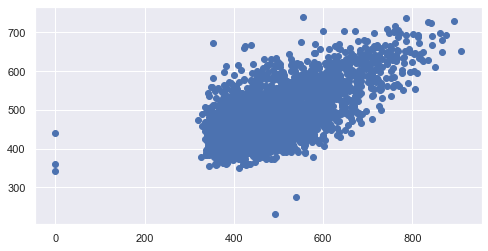

In [46]:
plt.figure(figsize=(8,4))
plt.scatter(x = y_test, y=predict)
plt.show()

- Detectar outliers

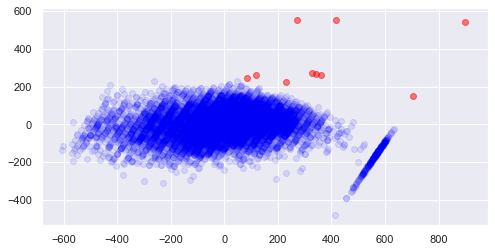

In [47]:

plt.figure(figsize(8,4))
# Utilizando as configurações abaixo para validar a precisão: n_neighbors=20
detector_outlier = LocalOutlierFactor(novelty=True, contamination=0.001).fit(X)
predict_outlier = detector_outlier.predict(X)==-1

#transforma em dados de treino em 2 componentes para faciliar a visualização
pca_outlier = PCA(n_components=2).fit(X)

train_points = pca_outlier.transform(X[~predict_outlier])
plt.scatter(train_points[:, 0], train_points[:, 1], c='blue', alpha=0.1)


outliers = pca_outlier.transform(X[predict_outlier])
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', alpha=0.5);

plt.show()

In [48]:
#Serão removidos dados identificados como outliers
len(predict_outlier[predict_outlier == True])/predict_outlier.shape[0] *100

0.09903931860948798

In [49]:
X = X[~predict_outlier]
y = y[~predict_outlier]

In [50]:
X_stand_train, X_stand_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=250)
regr_stand = linear_model.LinearRegression()
regr_stand.fit(X_stand_train, y_train)
predict_stand = regr_stand.predict(X_stand_test)
print('Mean squared error: ' ,mean_squared_error(y_test, predict_stand))
print('R2 score: ', r2_score(y_test, predict_stand))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict_stand), X_stand_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict_stand, X_stand_test))

Mean squared error:  5622.972065002045
R2 score:  0.4383299286492509
Adjusted R2: 0.43616035178769696
Predicted R2: 0.42944170283255945


- Aplicar PCA com dados retirando os outliers

In [51]:
pca = PCA().fit(X)

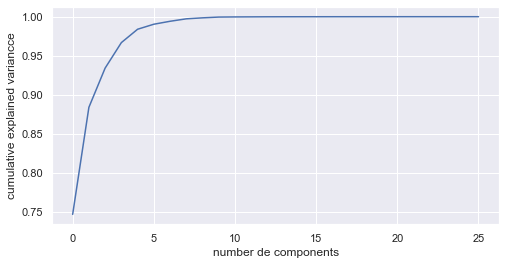

In [52]:
plt.figure(figsize=(8,4)) 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number de components')
plt.ylabel('cumulative explained variancce')
plt.show()

In [53]:
X_pca = PCA(n_components=8).fit_transform(X)
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.33, random_state=250)
regr_pca = linear_model.LinearRegression()
regr_pca.fit(X_pca_train, y_train)
predict_pca = regr_pca.predict(X_pca_test)

In [54]:
print('Mean squared error: ' ,mean_squared_error(y_test, predict_pca))
print('R2 score: ', r2_score(y_test, predict_pca))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict_pca), X_pca_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict_pca, X_pca_test))

Mean squared error:  6003.516731317398
R2 score:  0.40031790450781246
Adjusted R2: 0.39960706486283737
Predicted R2: 0.39724904344187517


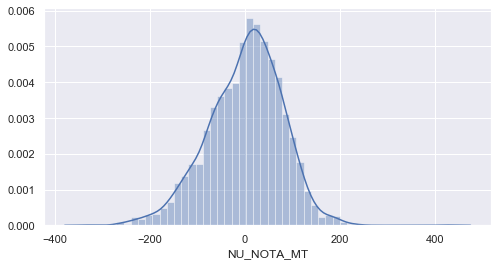

In [55]:
plt.figure(figsize=(8,4)) 
residuos = predict_pca - y_test
sns.distplot(residuos)
plt.show()

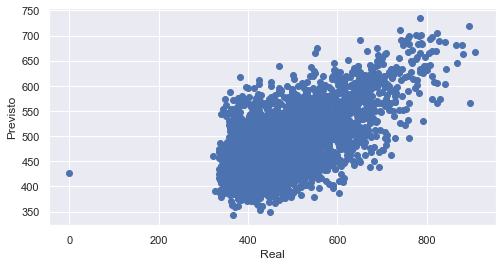

In [56]:
plt.figure(figsize=(8,4)) 
plt.scatter(x = y_test, y=predict_pca)
plt.xlabel("Real")
plt.ylabel("Previsto")
plt.show()

### GridSearchCV

Utilizando GridSearchCV na Regressão removendo os outliers sem PCA

In [57]:
parms = {'fit_intercept': [True, False],
        'normalize': [True, False],
        }
metricas = ['neg_mean_absolute_error', 'neg_mean_squared_error',   'r2']


In [58]:
# Busca os melhores parâmetros com cv=3(default) para todos as métricas definida a cima
grid_Search = GridSearchCV(regr_stand, param_grid=parms, scoring=metricas,
                          refit='neg_mean_squared_error', return_train_score=False, cv=50)

In [59]:
grid_Search = grid_Search.fit(X_stand_train, y_train)

In [60]:
# Considerando o refit='neg_mean_squared_error'
grid_Search.best_score_

-5438.236347104042

In [61]:
#A regressão esta dando um erro médio de 74,29
np.sqrt(grid_Search.best_score_*-1)

73.7443987507122

In [62]:
# A melhor combinação é a definida abaixo
grid_Search.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
pd.DataFrame(grid_Search.cv_results_).iloc[:,7:]

,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,split5_test_neg_mean_absolute_error,split6_test_neg_mean_absolute_error,split7_test_neg_mean_absolute_error,split8_test_neg_mean_absolute_error,split9_test_neg_mean_absolute_error,...,split43_test_r2,split44_test_r2,split45_test_r2,split46_test_r2,split47_test_r2,split48_test_r2,split49_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,-59.673930,-57.589338,-52.869634,-62.812962,-67.683253,-60.181149,-65.811577,-60.876822,-57.325491,-56.144684,...,0.267321,0.525928,0.449113,0.516453,0.458463,0.361006,0.422866,0.428227,0.085722,2
1,-59.675215,-57.591407,-52.868566,-62.820856,-67.689452,-60.176105,-65.811008,-60.876822,-57.325491,-56.140793,...,0.267301,0.525929,0.449113,0.516624,0.458540,0.361006,0.422859,0.428239,0.085720,1
2,-60.005055,-57.727813,-53.399401,-63.264976,-68.195707,-60.294073,-65.845668,-60.859709,-57.018347,-56.326007,...,0.279618,0.518621,0.459055,0.519005,0.463830,0.354782,0.422160,0.426439,0.087451,3
3,-60.005055,-57.727813,-53.399401,-63.264976,-68.195707,-60.294073,-65.845668,-60.859709,-57.018347,-56.326007,...,0.279618,0.518621,0.459055,0.519005,0.463830,0.354782,0.422160,0.426439,0.087451,3


In [64]:
# A primeira 0 é a melhor candidata
grid_Search.best_index_

1

In [65]:
best_reg = grid_Search.best_estimator_
predict_grid = best_reg.predict(X_stand_test)

In [66]:
print('Mean squared error: ' ,mean_squared_error(y_test, predict_grid))
print('R2 score: ', r2_score(y_test, predict_grid))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict_grid), X_pca_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict_grid, X_pca_test))

Mean squared error:  5622.972065002045
R2 score:  0.4383299286492509
Adjusted R2: 0.43766414696740097
Predicted R2: 0.4354647652099005


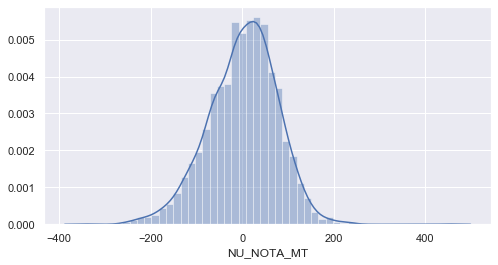

In [67]:
plt.figure(figsize=(8,4)) 
residuos = predict_grid - y_test
sns.distplot(residuos)
plt.show()

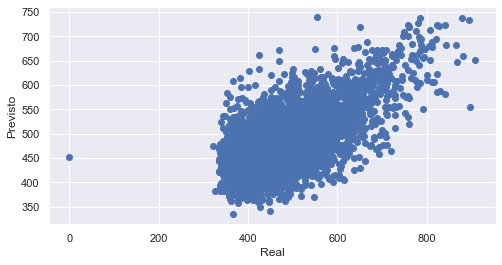

In [68]:
plt.figure(figsize=(8,4)) 
plt.scatter(x = y_test, y=predict_grid)
plt.xlabel("Real")
plt.ylabel("Previsto")
plt.show()

## Tratamento test.csv

In [69]:
# Optou-se por colocar a média das notas da base de treino na base de test
colunas = [ 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
        'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']
mean_train = df2.xs('train')[colunas].mean()
mean_train

NU_NOTA_COMP1      119.880361
NU_NOTA_COMP2      111.998019
NU_NOTA_COMP3      106.906012
NU_NOTA_COMP4      113.210360
NU_NOTA_COMP5       77.458156
NU_NOTA_REDACAO    529.452907
dtype: float64

# Arquivo para submissão

In [70]:
colunas = df2.drop(['NU_NOTA_MT', 'NU_INSCRICAO'], axis=1).columns
df_entrega = df2.xs('test')[colunas]

In [71]:
# Preenche dados Nan com a média da base de treino
df_entrega1 = df2.xs('test')[colunas].fillna(0)

modelo_preds = grid_Search.predict(df_entrega1)

In [72]:
df_submit = pd.DataFrame({
    'NU_INSCRICAO':df2.xs('test').NU_INSCRICAO,
    'NU_NOTA_MT':modelo_preds
})
df_submit.to_csv('answer.csv', index=False)